# Yelp Exploration

In [1]:
%matplotlib inline

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.feature_extraction.text import *
from sklearn import metrics

In [2]:
reviews = pd.read_csv('input/yelp_review.csv', nrows=10000)

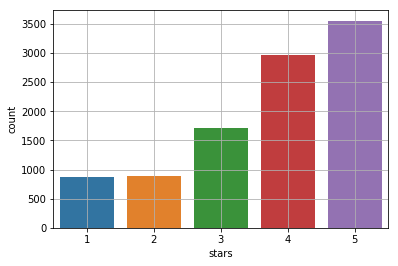

In [5]:
sns.countplot('stars', data=reviews)
plt.grid()
plt.show()

In [6]:
train_data, dev_data, train_labels, dev_labels = \
    train_test_split(reviews.text.values, reviews.stars.values, test_size=.1, random_state=0)

## Count Vectorizer

In [68]:
cv = CountVectorizer(stop_words='english')
train_dtm = cv.fit_transform(train_data)
dev_dtm = cv.transform(dev_data)

lr = LogisticRegression()
lr.fit(train_dtm, train_labels)

print(metrics.classification_report(dev_labels, lr.predict(dev_dtm)))

             precision    recall  f1-score   support

          1       0.65      0.55      0.60       103
          2       0.32      0.25      0.28        92
          3       0.27      0.29      0.28       149
          4       0.48      0.45      0.46       317
          5       0.61      0.68      0.64       339

avg / total       0.49      0.50      0.49      1000



In [67]:
len(cv.get_feature_names())

29890

## TFIDF Vectorizer

In [84]:
tv = TfidfVectorizer(stop_words='english')
train_dtm2 = tv.fit_transform(train_data)
dev_dtm2 = tv.transform(dev_data)

lr2 = LogisticRegression()
lr2.fit(train_dtm2, train_labels)

print(metrics.classification_report(dev_labels, lr2.predict(dev_dtm2)))

             precision    recall  f1-score   support

          1       0.77      0.54      0.64        94
          2       0.47      0.09      0.15        87
          3       0.47      0.29      0.36       175
          4       0.48      0.57      0.52       300
          5       0.59      0.78      0.68       344

avg / total       0.54      0.55      0.52      1000



## SVM

Interestingly, an SVM is horrible if we use the count vectorizer but on par with logistic regression if we use the tf-idf vectorizer.  Fitting is also much faster with tf-idf as well.

In [88]:
svc = LinearSVC()
svc.fit(train_dtm, train_labels)
print(metrics.classification_report(dev_labels, svc.predict(dev_dtm)))

             precision    recall  f1-score   support

          1       0.10      0.10      0.10        94
          2       0.10      0.09      0.10        87
          3       0.21      0.22      0.21       175
          4       0.32      0.33      0.33       300
          5       0.33      0.33      0.33       344

avg / total       0.27      0.27      0.27      1000



In [89]:
svc2 = LinearSVC()
svc2.fit(train_dtm2, train_labels)
print(metrics.classification_report(dev_labels, svc2.predict(dev_dtm2)))

             precision    recall  f1-score   support

          1       0.68      0.65      0.66        94
          2       0.38      0.24      0.30        87
          3       0.38      0.33      0.35       175
          4       0.45      0.50      0.47       300
          5       0.62      0.68      0.65       344

avg / total       0.51      0.52      0.52      1000

